In [140]:
import numpy as np
import cProfile
import itertools
import heapq

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resolvendo o problema do quebra-cabeças de 8 peças com o algoritmo A*: passo a passo

O quebra cabeça numérico de 8 peças, consiste em um tabuleiro 3x3, onde a partir de um estado inicial, deseja-se chegar em um estado objetivo. Nesse notebook, nosso objetivo será formar uma sequência de 1 a 8, movimentando as peças para o espaço em branco, como mostrado na figura abaixo.

![title](images\8puzzle.png)



Esse problema pertence à família de quebra-cabeças de blocos deslizantes, que são **frequentemente usados como problemas de teste para novos algoritmos de busca em Inteligência Artificial.**

Existem diversos algoritmos de busca, como por exemplo a busca em largura (BrFS - Breadth-first search), que também podemos chamar de "busca cega", pois ela não tem nenhuma informação adicional sobre estados. Apenas vão gerando sucessores e distinguindo se o sucessor gerado é ou não o estado objetivo.

Já algoritmos de busca que conseguem nos dizer se um estado não objetivo é mais promissor do que outro são chamadas de busca informada (heurística), categoria em que se enquadra o algoritmo A* (A estrela). 

Nesse notebook, vamos explorar o problema do quebra cabeça de 8 peças usando o algoritmo A*, para encontrar o melhor caminho para chegarmos ao nosso estado objetivo.

# A * (A Star)

A* é um algoritmo de busca informada ou heurística, o que significa que ele usa uma estimativa do custo para atingir a meta do nó atual para tomar decisões inteligentes sobre quais nós explorar em seguida.

É a solução mais amplamente conhecida da busca de melhor escolha. Basicamente, esse algoritmo avalia quais nós serão explorados, com base no menor valor da função de avaliação f(n), que por sua vez é uma combinação de g(n), o custo para alcançar o estado, e h(n), o custo para ir do nó ao objetivo.

Então, temos: f(n) = g(n) + h(n)

h(n) é a função definida pela heurística do problema. Essa heurística, utiliza conhecimento de um problema específico além da definição do problema em si. Pensando no nosso problema do quebra-cabeça, podemos pensar em duas heurísticas:

1. O número de peças em posição errada
2. O número de movimentos necessários para atingir a posição correta

Pegando o estado inicial abaixo, podemos dizer que o h(n) utilizando a heurística 1 seria igual a 8, e para a heurística 2 igual a 16.

![title](images\estado_inicial.png)

Como podemos notar, a heurística 1 é extremamente otimista, pois estamos desconsiderando as ações permitidas do problema em si. Usando essa premissa, poderíamos dizer que para chegar ao estado objetivo, bastaria apenas retirar cada peça da posição errada, e colocar na posição correta em apenas 1 movimento.

Já a heurística 2, é mais realista, mas **mantendo o critério de admissibilidade, condição para a otimalidade (a estratégia encontra a solução ótima, quando existe) do algoritmo A*. Uma heurística admissível jamais irá superestimar o verdadeiro custo de uma solução**. Mais a frente, vamos comparar os resultados utilizando as duas heurísticas aqui apresentadas e o impacto no desempenho do algoritmo.

## Funcionamento básico do A*

Vamos para o funcionamento do algoritmo. Como mostrado na imagem abaixo, definimos nosso estado inicial (à esquerda), e estado objetivo (à direita)!

![title](images\8puzzle.png)

De forma geral, precisamos fazer a gestão de duas estruturas de dados, o que vamos chamar de OPEN e CLOSE.

OPEN contém todos os nós que foram gerados, mas não foram explorados, ou seja, os estados futuros do nó atual ainda não foram criados. Essa é uma lista de "pending tasks", sendo gerida por uma fila de prioridade baseada em f(n). CLOSE contém os nós que foram gerados e expandidos. 

Dessa forma, temos 5 passos básicos do algoritmo:

1. Adicionamos o nó do estado inicial na lista OPEN

2. Removemos da OPEN o nó atual com o menor f(n), no primeiro passo, será sempre o estado inicial.

3. Se o estado do nó atual selecionado for igual ao estado objetivo, encontramos a solução, recuperamos o caminho! Importante dizer, que a verificação do estado inicial com o estado final é feito no momento da expansão, e não no momento que um nó é gerado. Dessa forma, garantimos encontrar o caminho mais curto, e não retornar o primeiro caminho encontrado.

4. Gera-se todos os estados possíveis a partir do nó atual, e calcula-se o f(n) de cada sucessor.

5. Para cada sucessor do nó atual, adicionamos na lista OPEN, caso o estado ainda não esteja na lista CLOSE.

Esse processo é exemplificado na imagem abaixo. Temos o estado inicial, que a partir dele, temos mais 4 estados possíveis. Estado inicial é adicionado na CLOSE LIST, pois já foi expandido, e seus sucessores na OPEN LIST em ordem de f(n). Dessa forma, o próximo nó a ser expandido será aquele com menor f(n).


![title](images\exemplo_exec.png)

# Implementação

O primeiro passo, é criar nossa classe Node, que será responsável por guardar informações do nosso estado, e seu antecessor para que conseguimos recuperar o caminho quando o estado objetivo for encontrado.

In [14]:
class Node:
    def __init__(self, state,  parent=None, gn=0, fn=0):
        self.state = state
        self.parent = parent
        self.gn = gn
        self.fn = fn

O segundo passo, é a gestão da nossa lista OPEN. Nessa implementação, criamos uma lista de "tasks", ou seja, nós na nossa OPEN list que está sendo administrada por uma fila de prioridade (aqui usamos a biblioteca heapq do python). Uma boa implementação dessa fila de prioridade é fundamental para uma execução mais eficiente!

Adicionamos um nó na lista OPEN apenas se ele não existe, ou, caso exista, e o f(n) atual for menor, fazemos a substituição. Dessa forma, garantimos que não iremos expandir estados com um custo maior do que o necessário.

In [130]:
class PriorityQueue():

    REMOVED = '<removed-task>'     

    def __init__(self):
        self.pq = []
        self.entry_finder = {} 
        self.counter = itertools.count()  
        #self.counter_opened = itertools.count()
        #self.count_opened = 0
        self.count = 0

    def add_task(self, task, node, priority=0):
        'Add a new task or update the priority of an existing task'
        if(task in self.entry_finder and priority >= self.entry_finder[task][0]):
            return
        if (task in self.entry_finder and priority < self.entry_finder[task][0]):
            self.remove_task(task)
            self.count = self.count - 1
        count = next(self.counter)
        entry = [priority, count, task, node]
        self.entry_finder[task] = entry
        heapq.heappush(self.pq, entry)
        #self.count_opened = next(self.counter_opened)
        self.count = self.count +1

    def remove_task(self,task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, count, task, node = heapq.heappop(self.pq)
            if node is not self.REMOVED:
                del self.entry_finder[task]
                return True, task, node
            
        return False, None, None 

Outra parte importante antes de partirmos para a implementação do A* de fato, é definir as funções de cálculos da nossa heurística (getCustoHeuristica1 e getCustoHeuristica2) bem como a definição de ações possíveis (get_sucessors), ou seja, como a expansão é feita.

In [4]:
def getPosition(state, element):
    # Iterate through rows and columns to find the indices
    for row_index, row in enumerate(state.state):
        for col_index, value in enumerate(row):
            if value == element:
                return (row_index, col_index)

def getCustoHeuristica2(state, obj_state):

    #Sum of the Manhattan distances of each element to its final position
    elements = [1,2,3,4,5,6,7,8]
    custo = 0

    for element in elements:
         
    
        point1 = getPosition(obj_state, element)
        point2 = getPosition(state, element)

        x1, y1 = point1
        x2, y2 = point2

        custo+= abs(x2 - x1) + abs(y2 - y1)


    return custo

def getCustoHeuristica1(state, obj_state):
    state_node = np.array(state.state)
    state_goal = np.array(obj_state.state)

    differences = 0
    
    # Count differences using element-wise comparison
    differences = np.sum(state_node != state_goal)

    return differences - 1

def get_sucessors(node):
    x, y = tuple(getPosition(node, 0))
    sucessors = []

    # Add adjacent nodes (up, down, left, right)
    for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:

        new_x, new_y = x + dx, y + dy
        if(((new_x > 2 or new_y > 2) or (new_x < 0 or new_y < 0))):
            continue

        updated_state = [[element for element in row] for row in node.state] 
        temp_value = node.state[new_x][new_y]
        updated_state[new_x][new_y] = node.state[x][y]
        updated_state[x][y] = temp_value

        new_node = Node(updated_state, parent=node, gn=node.gn + 1)
        sucessors.append(new_node)

    return sucessors

## Implementação do A*

In [111]:
def astar(start, goal, heuristic):

    print("Executanto algoritmo A* com heuristica ", heuristic)

    
    open_list = PriorityQueue()
    closed_list = set()
    number_visited_states = 0
    states_visited = []
    status=True
    total_cost = 0
    goal_state = tuple([element for sublist in goal.state for element in sublist])

    # Put node_start in the OPEN list with
    state_inicial = tuple([element for sublist in start.state for element in sublist])
    if(heuristic == 1):
        fn = start.gn + getCustoHeuristica1(start, goal)
        start.fn = fn
        open_list.add_task(state_inicial, start, fn)
    
    elif(heuristic == 2):
        fn = start.gn + getCustoHeuristica2(start, goal)
        start.fn = fn
        open_list.add_task(state_inicial, start, fn)
    
    
    while status:
        #Take from the open list the node node_current with the lowest cost
        status, task, current_node = open_list.pop_task()


        if(status == False):
            print("Não existe solução")
    
            return [], open_list, closed_list, 0, 0

        if (task == goal_state):
                # Goal reached, construct and return the path
                path = []
                fns_teste = []
                prof = current_node.gn
                while current_node:
                    path.append(current_node.state)
                    fns_teste.append(current_node.fn)
                    total_cost = total_cost + current_node.fn
                    current_node = current_node.parent
                return path[::-1],  open_list, closed_list, prof, total_cost

        closed_list.add(task)

        
        # Generate each state node_successor that come after node_current
        states_visited.append(task)
        for sucessor in get_sucessors(current_node):
            #if node in closed list, it has been expanded already
            if tuple([element for sublist in sucessor.state for element in sublist]) in closed_list:
                continue

            gn = current_node.gn + 1
            
            if(heuristic == 1):
                fn = gn + getCustoHeuristica1(sucessor, goal)
       
            elif(heuristic == 2):
                fn = gn + getCustoHeuristica2(sucessor, goal)
    

            sucessor.fn = fn
            
            state_atual = tuple([element for sublist in sucessor.state for element in sublist])
            open_list.add_task(state_atual, sucessor, fn)

    return [], open_list, closed_list, 0, number_visited_states

É possível determinar se o puzzle tem ou não solução a partir do estado inicial, contando o número de inversões. 

In [6]:
def count_inversions(state):
    inversion_count = 0
    flatten_state = [value for row in state for value in row if value != 0]

    for i in range(len(flatten_state)):
        for j in range(i + 1, len(flatten_state)):
            if flatten_state[i] > flatten_state[j]:
                inversion_count += 1

    return inversion_count

def is_solvable(initial_state, goal_state):
    initial_inversions = count_inversions(initial_state)
    goal_inversions = count_inversions(goal_state)

    if (initial_inversions % 2 == 0 and goal_inversions % 2 == 0) or \
       (initial_inversions % 2 != 0 and goal_inversions % 2 != 0):
        return True
    else:
        return False 

# Execução Pipeline

In [134]:
def main():

    
    initial_state_1 = [
        [7, 5, 3],
        [2, 0, 4],
        [6, 8, 1]
    ]

    not_solvable_1 = [
        [8, 4, 7],
        [6, 5, 0],
        [3, 2, 1]
    ]

    not_solvable_2 = [
        [8, 4, 7],
        [6, 5, 3],
        [0, 2, 1]
    ]

    not_solvable_3 = [
        [7, 5, 3],
        [2, 1, 4],
        [6, 8, 0]
    ]

    goal_state = [
        [0, 1, 2], 
        [3, 4, 5],
        [6, 7, 8]
    ]

    start = initial_state_1

    if is_solvable(start, goal_state):
        print("8 Puzzle nesse estado inicial tem solução")
    else:
        print("8 Puzzle nesse estado inicial não tem solução")

    print("\n")
    start = Node(start, gn=0, fn=0)
    obj_state = Node(goal_state, gn=0, fn=0)

    path, open_list, closed_list, prof, total_cost = astar(start, obj_state, heuristic=2)

    print("\n")
    print('Custo total esperado: ', total_cost)
    print("Número de estados expandidos: ", len(closed_list))
    print("Número de estados gerados: ", open_list.count)
    print('Número de estados na fronteira: ', len(open_list.entry_finder))


    if(path):
        print("Custo real da solução: ", prof)
        print("Caminho")
        for state in path:
            for row in state:
                print(row)
            print(" ")
    print("\n")
    print("-----------------------------------------------------------------------------------------------------------")
    print("\n")
    print("DETALHES TEMPO DE EXECUÇÃO \n\n")

if __name__ == '__main__':
    cProfile.run('main()')

8 Puzzle nesse estado inicial tem solução


Executanto algoritmo A* com heuristica  2


Custo total esperado:  502
Número de estados expandidos:  2492
Número de estados gerados:  3812
Número de estados na fronteira:  1319
Custo real da solução:  24
Caminho
[7, 5, 3]
[2, 0, 4]
[6, 8, 1]
 
[7, 0, 3]
[2, 5, 4]
[6, 8, 1]
 
[7, 3, 0]
[2, 5, 4]
[6, 8, 1]
 
[7, 3, 4]
[2, 5, 0]
[6, 8, 1]
 
[7, 3, 4]
[2, 0, 5]
[6, 8, 1]
 
[7, 0, 4]
[2, 3, 5]
[6, 8, 1]
 
[0, 7, 4]
[2, 3, 5]
[6, 8, 1]
 
[2, 7, 4]
[0, 3, 5]
[6, 8, 1]
 
[2, 7, 4]
[3, 0, 5]
[6, 8, 1]
 
[2, 0, 4]
[3, 7, 5]
[6, 8, 1]
 
[2, 4, 0]
[3, 7, 5]
[6, 8, 1]
 
[2, 4, 5]
[3, 7, 0]
[6, 8, 1]
 
[2, 4, 5]
[3, 7, 1]
[6, 8, 0]
 
[2, 4, 5]
[3, 7, 1]
[6, 0, 8]
 
[2, 4, 5]
[3, 0, 1]
[6, 7, 8]
 
[2, 0, 5]
[3, 4, 1]
[6, 7, 8]
 
[0, 2, 5]
[3, 4, 1]
[6, 7, 8]
 
[3, 2, 5]
[0, 4, 1]
[6, 7, 8]
 
[3, 2, 5]
[4, 0, 1]
[6, 7, 8]
 
[3, 2, 5]
[4, 1, 0]
[6, 7, 8]
 
[3, 2, 0]
[4, 1, 5]
[6, 7, 8]
 
[3, 0, 2]
[4, 1, 5]
[6, 7, 8]
 
[3, 1, 2]
[4, 0, 5]
[6, 7, 8]
 
[3, 1, 

# Comparando Heurísticas

In [135]:
initial_state_1 = [
    [7, 5, 3],
    [2, 0, 4],
    [6, 8, 1]
]

initial_state_2 = [
    [7, 5, 3],
    [1, 2, 4],
    [6, 8, 0]
]

initial_state_3 = [
    [7, 2, 4],
    [1, 5, 3],
    [6, 8, 0]
]

initial_state_4 = [
    [7, 2, 4],
    [8, 1, 3],
    [6, 5, 0]
]

goal_state = [
    [0, 1, 2], 
    [3, 4, 5],
    [6, 7, 8]
]


solvable_states = [initial_state_1, initial_state_2, initial_state_3, initial_state_4]


In [136]:
dict_comp = {
    'initial_state': [],
    'heuristic': [],
    'expanded_nodes': [],
    'created_nodes': [],
    'nodes_border': [],
    'prof_soluc': []
}

goal_state = [
    [0, 1, 2], 
    [3, 4, 5],
    [6, 7, 8]
]

heuristics = [1,2]
for heuristic in heuristics:
    for initial_state in solvable_states:
        start = initial_state

        start = Node(start, gn=0)
        obj_state = Node(goal_state, gn=0)

        path, open_list, closed_list, prof, total_cost = astar(start, obj_state, heuristic)

        print("\n")
        dict_comp['initial_state'].append(tuple([element for sublist in start.state for element in sublist]))
        dict_comp['heuristic'].append(heuristic)
        dict_comp['expanded_nodes'].append(len(closed_list))
        dict_comp['created_nodes'].append(open_list.count)
        dict_comp['nodes_border'].append(len(open_list.entry_finder))
        dict_comp['prof_soluc'].append(prof)

result = pd.DataFrame(dict_comp)
result

Executanto algoritmo A* com heuristica  1


Executanto algoritmo A* com heuristica  1


Executanto algoritmo A* com heuristica  1


Executanto algoritmo A* com heuristica  1


Executanto algoritmo A* com heuristica  2


Executanto algoritmo A* com heuristica  2


Executanto algoritmo A* com heuristica  2


Executanto algoritmo A* com heuristica  2




,initial_state,heuristic,expanded_nodes,created_nodes,nodes_border,prof_soluc
0,"(7, 5, 3, 2, 0, 4, 6, 8, 1)",1,22944,33229,10284,24
1,"(7, 5, 3, 1, 2, 4, 6, 8, 0)",1,3507,5524,2016,20
2,"(7, 2, 4, 1, 5, 3, 6, 8, 0)",1,3640,5768,2127,20
3,"(7, 2, 4, 8, 1, 3, 6, 5, 0)",1,8483,12926,4442,22
4,"(7, 5, 3, 2, 0, 4, 6, 8, 1)",2,2492,3812,1319,24
5,"(7, 5, 3, 1, 2, 4, 6, 8, 0)",2,455,703,247,20
6,"(7, 2, 4, 1, 5, 3, 6, 8, 0)",2,561,905,343,20
7,"(7, 2, 4, 8, 1, 3, 6, 5, 0)",2,838,1312,473,22


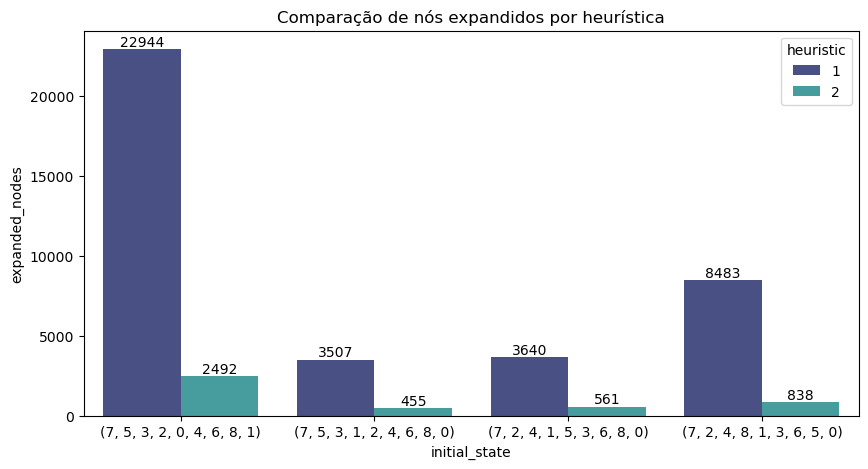

In [137]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='expanded_nodes',
                 hue='heuristic', data=result,
                 errwidth=0,
                 palette="mako")
 
ax.set_title('Comparação de nós expandidos por heurística')

for i in ax.containers:
    ax.bar_label(i,)

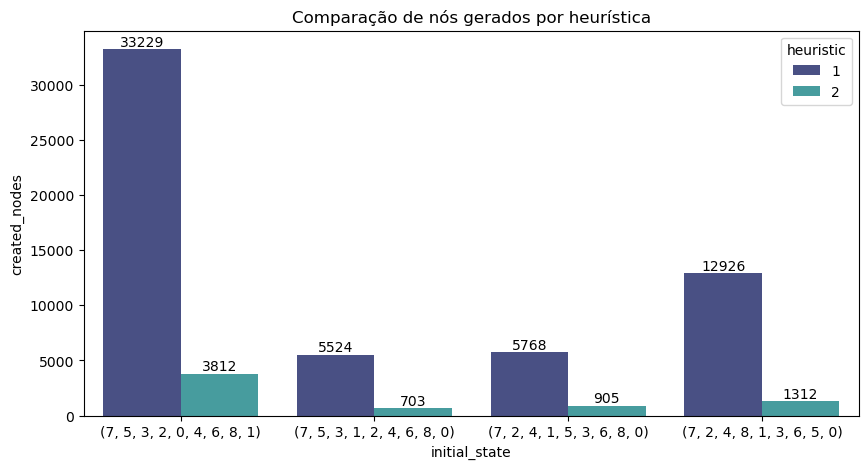

In [138]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='created_nodes',
                hue='heuristic', data=result,
                errwidth=0,
                palette="mako")
 
ax.set_title('Comparação de nós gerados por heurística')

for i in ax.containers:
    ax.bar_label(i,)

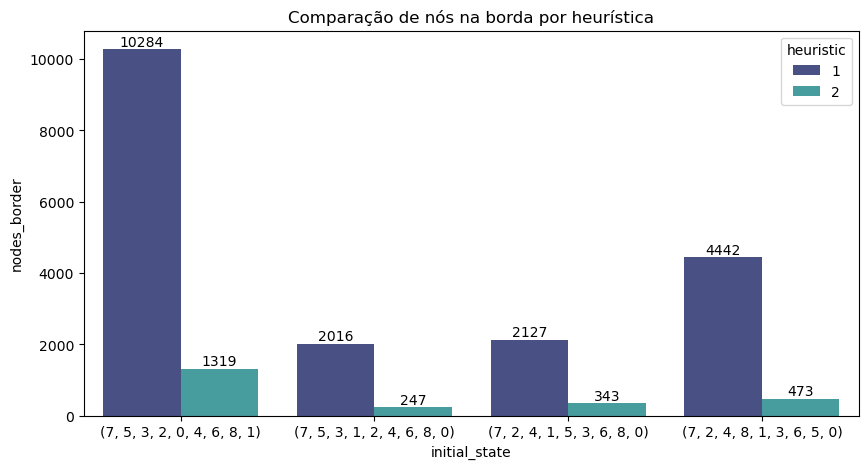

In [139]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='nodes_border',
                 hue='heuristic', data=result,
                 errwidth=0,
                 palette="mako")
 
ax.set_title('Comparação de nós na borda por heurística')

for i in ax.containers:
    ax.bar_label(i,)

Como podemos notar, a escolha da heurística no algoritmo A* é crucial porque influencia diretamente a eficiência, precisão e desempenho geral do algoritmo. Uma boa heurística orienta a busca efetivamente em direção à solução ótima, reduzindo os requisitos computacionais e tornando A* uma ferramenta poderosa para resolver problemas complexos de localização de caminhos e travessia de grafos.